# Verilog HDL Verification Using Python

We have a fun tutorial this month. It is a simple adder design and verification using Verilog HDL using Python. We will generate input testvectors and verify the simulation results using Python. Main outline of the tutorial is shown in Figure 1 below. 

<img src="io.png" alt="Drawing" style="width: 500px;"/>
<div align="center">
  Figure 1. Python Based Automated Verification System
</div>

The DUT is a simple adder. It calculates A + B = Z where both A and B are 16 bits and output Z is 17 bits. The ```adder.v``` is shown below. 

```verilog
// DUT
// adder.v
module add(A,B,Z);
parameter N = 16;
input [N-1:0] A,B;
output [N:0] Z;

assign Z = A+B;

endmodule
```
The testbench is shown below. Code explaination will be done during a video tutorial. Please check the link. 

```
// Testbench
// test_file.v
`include "add.v"

module test_file;
parameter i =1;   
integer read_file,write_file,value_r;
reg clk;
reg [15:0] A;
reg [15:0] B;
wire [16:0] Sum; 

add aa1(A,B,Sum);

initial begin
    clk = 1;
    A = 0;
    B = 0;
    read_file  = $fopen("in_vec.txt","r");
    write_file = $fopen("out_vec.txt","w");
end

always # 1 clk = ~clk;

initial begin
     @ (posedge clk);
    while (!$feof(read_file)) 
    begin
      @ (posedge clk);
      value_r = $fscanf(read_file,"%h %h\n",A,B);
    end
     @ (posedge clk);
    $fclose(read_file);
    $fclose(write_file);
    #1 $finish;
end

always @ (negedge clk)
 begin
$fwrite(write_file,"%0d %0d %0d\n",A,B,Sum);
 end

initial $monitor($time, " %d + %d = %d",A,B,Sum);
/*
initial  
begin
    $fdisplay(write_file, "\nNew addition :%d\n", i);
    $fdisplay(write_file, "_____________________________\n");
end
*/
endmodule
```


## Testvector Generator

Now we can generate our testvector file ```in_vec.txt``` based on user input paramaters. Please see comment lines for explanation for each line.  

In [22]:
import numpy as np # import numpy library
n=int(input("Enter input bit size (default 16): ")) # ask user number of bits
N=int(input("Enter number of testvector: ")) # ask user number of testvectors
k=int(input("Enter number inputs: ")) # ask user number of inputs. Our adder has 2 (A and B)
test_vectors = np.uint32(2**n*np.random.rand(N,k)) # this will generate (N,k) numpy array 

Enter input bit size (default 16):  32
Enter number of testvector:  1000
Enter number inputs:  2


In [23]:
# now we can save our array into a file (in_vec.txt). This file will contains 
# A and B inputs. These are 16-bit hext numbers and separated by space
# we can also create A and B separate files 

np.savetxt('in_vec.txt', test_vectors, delimiter=' ',fmt="%.4X") 

I am using a Mac computer and will compile and simulate the Verilog code using ```Iverilog```.  We can run command line code in Jupyter using ```exclamation mark``` front of the code. if you do not see the terminal display in here please comment out ```initial $monitor($time, " %d + %d = %d",A,B,Sum);```
The code below will compile and simulate the testbench and generate ```out_vec.txt``` file that contains ```A``` , ```B``` and ```Sum``` values. Now we can open this file in Python and see if calculations are correct. 

In [40]:
!iverilog test_file.v
!vvp a.out

test_file.v:35: $finish called at 2005 (1s)


## Verification 

Now we can open the ```out_vec.txt``` file using ```Pandas``` library by skipping the two rows (due to assign zero values in the beginning of simulation). 

In [41]:
Values=np.loadtxt("out_vec.txt",delimiter=' ',skiprows=2)


In [16]:
import pandas as pd
AA=pd.read_csv("out_vec.txt",delimiter=' ',header=None,skiprows=2)
AA

,0,1,2
0,6942,2262,9204
1,65293,10504,75797
2,8340,31582,39922
3,19274,44790,64064
4,47155,192,47347
...,...,...,...
95,26928,38157,65085
96,20695,24565,45260
97,23422,2794,26216
98,64357,24609,88966


In [27]:
Values=AA.values # This will get the three column numpy array

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [42]:
Values

array([[ 36569.,  13320.,  49888.],
       [ 13245.,   4362.,  17606.],
       [ 39911.,  13416.,  53326.],
       ...,
       [ 34336.,  59693.,  94028.],
       [ 48316.,  56130., 104445.],
       [ 56856.,  50499., 107354.]])

In [43]:
A=Values[:,0] # A vector values
B=Values[:,1] # B vector values
Out=Values[:,2] # Sum vector values
N=np.arange(0,A.size) # size of the vector (this is the same as number of testvectors N)

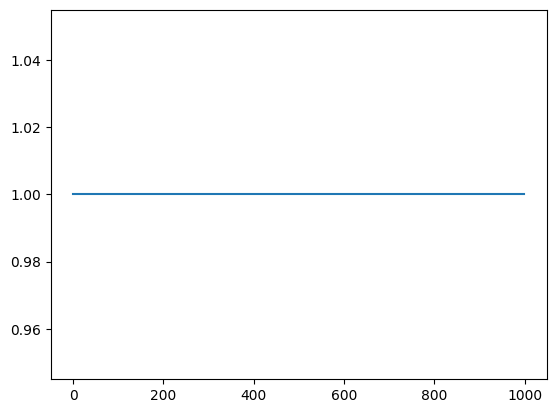

In [44]:
# Now we want to see if A+B equals to Sum
# We will use matplotlib library to plot abs(A+B-Sum). All values should be zero

import matplotlib.pyplot as plt
test=abs(A+B-Out);
plt.plot(N,test)
plt.show()

Now we can see how many of the testvectors passed and how many of them failed. 

In [45]:
k=0;
j=0;
for i in (test):
    if (i<1e-16):
        #print('Passed')
        k=k+1
    else:
        #print("Failed")
        j=j+1
print(f"Total number of testvectors \t: {len(test)}")
print(f"Total number of passes \t\t: {k}")
print(f"Total number of fails \t\t: {j}")
print(f"Error (%) \t\t\t: %{100*j/(j+k)}")

Total number of testvectors 	: 1000
Total number of passes 		: 0
Total number of fails 		: 1000
Error (%) 			: %100.0
